In [ ]:
# !pip install opencv-python matplotlib imageio gdown tensorflow==2.16.1

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
  Using cached matplotlib-3.9.3-cp310-cp310-win_amd64.whl (7.8 MB)
  Using cached imageio-2.36.1-py3-none-any.whl (315 kB)
     -------------------------------------- 376.9/376.9 MB 5.0 MB/s eta 0:00:00
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl (413 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
     -------------------------------------- 127.8/127.8 kB 3.8 MB/s eta 0:00:00
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached wrapt-1.17.0-cp310-cp310-win_amd64.whl (38 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached grpcio-1.68.1-cp310-cp310-win_amd64.whl (4.4 MB)
  Using cached h5py-3.12.1-cp310-cp310-w


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# !pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\noobs\appdata\local\programs\python\python310\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [3]:
import os
import tensorflow as tf
import cv2
import gdown
import matplotlib.pyplot as plt
from typing import List
import numpy as np
from tensorflow.keras import backend as K

In [ ]:
physical_device = tf.config.list_physical_devices('GPU')
if physical_device:
    try:
        tf.config.experimental.set_memory_growth(physical_device[0], True)
    except:
        pass

In [ ]:
# url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
# output = "data.zip"
# gdown.download(url, output, quiet=False)
# gdown.extractall("data.zip")

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [6]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get((cv2.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32)/std

In [7]:
print(char_to_num(['v','a','i','b']))
print(num_to_char([22,  1,  9,  2]))

tf.Tensor([22  1  9  2], shape=(4,), dtype=int64)
tf.Tensor([b'v' b'a' b'i' b'b'], shape=(4,), dtype=string)


In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # print(f'This is the path: {path}')
    # file_name = path.split('\\')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [10]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files('data/s1/*.mpg') 
data = data.shuffle(500)
data = data.map(mappable_function) 
data = data.padded_batch(2, padded_shapes=([75,None,None,None], [40])) 

data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)


In [12]:
len(train), len(test)

(450, 50)

In [ ]:
videos, alignments = data.as_numpy_iterator().next()

In [14]:
print(f'This is a video shape : {videos.shape}')

This is a video shape : (2, 75, 46, 140, 1)


In [15]:
len(videos), len(alignments)

(2, 2)

In [16]:
sample = data.as_numpy_iterator().next()


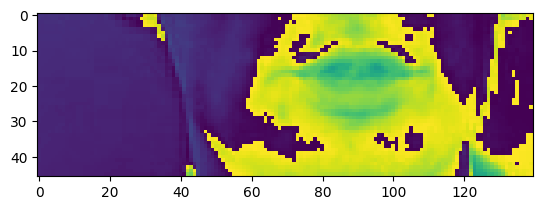

In [ ]:
plt.imshow(sample[0][1][40])
# plt.imshow(videos[0][40]) # both are the same

In [18]:
 test_path = "data/s1/bbaf2n.mpg"

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
print(f'whole the frame: {frames.shape}') 
frames[0]

whole the frame: (75, 46, 140, 1)


<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991663 ],
        [1.4991663 ],
        [1.4616871 ],
        ...,
        [0.41227072],
        [0.41227072],
        [0.41227072]],

       [[1.4991663 ],
        [1.4991663 ],
        [1.4616871 ],
        ...,
        [0.41227072],
        [0.41227072],
        [0.41227072]],

       [[1.4616871 ],
        [1.4616871 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       ...,

       [[1.0494163 ],
        [1.0494163 ],
        [1.0119373 ],
        ...,
        [0.11243746],
        [0.11243746],
        [0.07495831]],

       [[1.0494163 ],
        [1.0494163 ],
        [1.0119373 ],
        ...,
        [0.11243746],
        [0.07495831],
        [0.07495831]],

       [[1.0494163 ],
        [1.0494163 ],
        [1.0119373 ],
        ...,
        [0.07495831],
        [0.07495831],
        [0.03747915]]], dtype=float32)>

This is the alingments of the one video: [ 2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23]
 


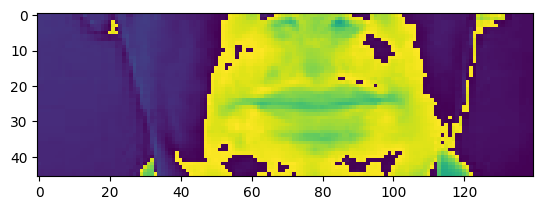

In [25]:
print(f'This is the alingments of the one video: {alignments}')
print(' ')
tf.strings.reduce_join([bytes.decode(i) for i in num_to_char(alignments.numpy()).numpy()])
plt.imshow(frames[74])

In [ ]:
print(tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]]))
print(tf.strings.reduce_join([num_to_char(word) for word in sample[1][1]]))


tf.Tensor(b'bin green at n six please', shape=(), dtype=string)
tf.Tensor(b'bin red with t four now', shape=(), dtype=string)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, TimeDistributed, Reshape, Bidirectional, LSTM, Dropout, Dense, Activation

In [23]:
print(f'This is a video shape: {data.as_numpy_iterator().next()[0].shape}') #   data.as_numpy_iterator().next()[0][0].shape
print(f'This is a alignment shape: {data.as_numpy_iterator().next()[1].shape}')

This is a video shape: (2, 75, 46, 140, 1)
This is a alignment shape: (2, 40)


In [24]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int64)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int64)
    label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int64)
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [25]:
class ProductExampleCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs = None) -> None:
        data = self.dataset.next()
        yhat = model.predict(data[0])
        decode = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join([num_to_char(word) for word in data[1][x]]).numpy().decode('utf-8'))
            print('Predicted: ', tf.strings.reduce_join([num_to_char(word) for word in decode[x]]).numpy().decode('utf-8'))

            print('~'*100)

In [ ]:
# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(TimeDistributed(Reshape((-1,))))

# model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Dense(char_to_num.vocabulary_size()+1,  kernel_initializer='he_normal', activation='softmax'))


model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Reshape((-1,))))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


c:\Users\noobs\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 46, 140,    │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 23, 70,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 11, 35, 75) │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,473,760 (32.32 MB)

 Trainable params: 8,472,842 (32.32 MB)

 Non-trainable params: 918 (3.59 KB)

In [28]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


In [29]:
yhat[0].shape

(75, 41)

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"mmmt'''twwwwwwwwwwwwwwwtttttwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww99">

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [33]:
example_callback = ProductExampleCallback(test)

In [34]:
model.compile(loss=CTCLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
file_id = ''
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'new_best_weights2.weights.h5', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Xl2VrkQFWpn2O612qyDinN8L_kyFzv08
To: d:\Projects\DeepLearning\LipApp\new_best_weights2.weights.h5
100%|██████████| 102M/102M [00:17<00:00, 5.77MB/s] 


'new_best_weights2.weights.h5'

In [36]:
model.load_weights('new_best_weights2.weights.h5')

c:\Users\noobs\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_data = test.as_numpy_iterator()

In [38]:
sample = test_data.next()

In [39]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


In [40]:
print('='*100)
print('This is original text: ')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

This is original text: 


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in n three againbin white by n two now'>]

In [41]:
decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=True)[0][0].numpy()

In [42]:
print("="* 100)
print('This is prediction: ')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

This is prediction: 


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in n three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white by n two now'>]

## **Test On Videos**

In [48]:
sample2 = load_data(tf.convert_to_tensor('data/s1/bbaz4n.mpg'))

In [49]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample2[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

In [50]:
yhat = model.predict(tf.expand_dims(sample2[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


In [51]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [52]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

In [42]:
# Resume training from epoch 75
model.fit(
    train,
    validation_data=test,
    epochs=150,
    initial_epoch=100,  # Start from epoch 75
    callbacks=[checkpoint_callback, reduce_lr, early_stopping, example_callback]
)


Epoch 101/150
160/450 ━━━━━━━━━━━━━━━━━━━━ 3:35 742ms/step - loss: 5.8616

[mpeg1video @ 0x7addb408ea00] ac-tex damaged at 22 17
[mpeg1video @ 0x7addb408ea00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 5.8287

[mpeg1video @ 0x7addd00a5580] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd00a5580] Warning MVs not available



Epoch 101: val_loss did not improve from 2.98227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Original:  place blue by c five soon
Predicted:  place blue by c five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red at k nine again
Predicted:  lay red at v nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 5.8283 - val_loss: 3.0008 - learning_rate: 1.0000e-04
Epoch 102/150
268/450 ━━━━━━━━━━━━━━━━━━━━ 2:15 744ms/step - loss: 5.6942

[mpeg1video @ 0x7ade6c0a0a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade6c0a0a80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 5.7174

[mpeg1video @ 0x7adf280b7d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf280b7d00] Warning MVs not available



Epoch 102: val_loss improved from 2.98227 to 2.86376, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Original:  lay blue in x seven again
Predicted:  lay blue in x seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin blue with m six please
Predicted:  bin blue with h six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 5.7173 - val_loss: 2.8638 - learning_rate: 1.0000e-04
Epoch 103/150
139/450 ━━━━━━━━━━━━━━━━━━━━ 3:52 746ms/step - loss: 5.5231

[mpeg1video @ 0x7addd876d180] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd876d180] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 5.4480

[mpeg1video @ 0x7ade100abd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade100abd40] Warning MVs not available



Epoch 103: val_loss did not improve from 2.86376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original:  bin blue by f nine again
Predicted:  bin blue by f nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red in q six now
Predicted:  lay red in k six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 5.4481 - val_loss: 3.3282 - learning_rate: 1.0000e-04
Epoch 104/150
182/450 ━━━━━━━━━━━━━━━━━━━━ 3:19 746ms/step - loss: 4.9251

[mpeg1video @ 0x7addb406d0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addb406d0c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 5.1105

[mpeg1video @ 0x7addc9916b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7addc9916b40] Warning MVs not available



Epoch 104: val_loss did not improve from 2.86376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Original:  bin red by m six now
Predicted:  bin red by l six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white in c eight now
Predicted:  place white in c eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - loss: 5.1109 - val_loss: 3.3975 - learning_rate: 1.0000e-04
Epoch 105/150
276/450 ━━━━━━━━━━━━━━━━━━━━ 2:09 746ms/step - loss: 5.0768

[mpeg1video @ 0x7ade58082240] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade58082240] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 5.1221

[mpeg1video @ 0x7adf34010c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf34010c00] Warning MVs not available



Epoch 105: val_loss improved from 2.86376 to 2.50140, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Original:  lay red in q seven soon
Predicted:  lay red in d seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay blue at d nine again
Predicted:  lay blue at d nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 5.1222 - val_loss: 2.5014 - learning_rate: 1.0000e-04
Epoch 106/150
249/450 ━━━━━━━━━━━━━━━━━━━━ 2:29 744ms/step - loss: 5.1239

[mpeg1video @ 0x7addd409f680] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd409f680] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 5.2330

[mpeg1video @ 0x7ade08036e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade08036e80] Warning MVs not available



Epoch 106: val_loss did not improve from 2.50140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Original:  lay red by r seven again
Predicted:  lay red by s seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set green in o nine again
Predicted:  set gren in o nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - loss: 5.2331 - val_loss: 2.5599 - learning_rate: 1.0000e-04
Epoch 107/150
161/450 ━━━━━━━━━━━━━━━━━━━━ 3:35 746ms/step - loss: 5.1780

[mpeg1video @ 0x5aaefd4d8c00] ac-tex damaged at 22 17
[mpeg1video @ 0x5aaefd4d8c00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - loss: 5.3876

[mpeg1video @ 0x7addc403f680] ac-tex damaged at 22 17
[mpeg1video @ 0x7addc403f680] Warning MVs not available



Epoch 107: val_loss did not improve from 2.50140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Original:  set blue at t seven soon
Predicted:  set blue at t seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue by c four now
Predicted:  place blue by c four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - loss: 5.3879 - val_loss: 2.7255 - learning_rate: 1.0000e-04
Epoch 108/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - loss: 5.0255

[mpeg1video @ 0x7adf2c436300] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf2c436300] Warning MVs not available



Epoch 108: val_loss did not improve from 2.50140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Original:  place white with e three again
Predicted:  place white with thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin green with i one again
Predicted:  bin gren with i one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - loss: 5.0259 - val_loss: 2.6725 - learning_rate: 1.0000e-04
Epoch 109/150
397/450 ━━━━━━━━━━━━━━━━━━━━ 39s 747ms/step - loss: 5.2234

[mpeg1video @ 0x7addd4177800] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd4177800] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 5.2715

[mpeg1video @ 0x7addf00a4a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7addf00a4a40] Warning MVs not available



Epoch 109: val_loss did not improve from 2.50140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Original:  lay green in r eight now
Predicted:  lay gren in r eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set green in o seven soon
Predicted:  set gren in o seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - loss: 5.2724 - val_loss: 3.6413 - learning_rate: 1.0000e-04
Epoch 110/150
303/450 ━━━━━━━━━━━━━━━━━━━━ 1:50 749ms/step - loss: 5.2102

[mpeg1video @ 0x7adf4007da80] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf4007da80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - loss: 5.3072

[mpeg1video @ 0x7addd00e6480] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd00e6480] Warning MVs not available



Epoch 110: val_loss improved from 2.50140 to 2.34379, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Original:  bin blue in l four please
Predicted:  bin blue in z four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay white in y six now
Predicted:  lay white in o six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 5.3078 - val_loss: 2.3438 - learning_rate: 1.0000e-04
Epoch 111/150
109/450 ━━━━━━━━━━━━━━━━━━━━ 4:14 746ms/step - loss: 5.0432

[mpeg1video @ 0x7ade20046780] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade20046780] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - loss: 4.8765

[mpeg1video @ 0x7adf280ef7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf280ef7c0] Warning MVs not available



Epoch 111: val_loss did not improve from 2.34379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Original:  lay red in k four please
Predicted:  lay red in k four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red by q zero please
Predicted:  place red by y zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 4.8766 - val_loss: 2.5431 - learning_rate: 1.0000e-04
Epoch 112/150
168/450 ━━━━━━━━━━━━━━━━━━━━ 3:31 748ms/step - loss: 4.6419

[mpeg1video @ 0x7addd40389c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd40389c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 4.7250

[mpeg1video @ 0x7addf00dd240] ac-tex damaged at 22 17
[mpeg1video @ 0x7addf00dd240] Warning MVs not available



Epoch 112: val_loss did not improve from 2.34379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Original:  lay blue sp at q five soon
Predicted:  lay blue at j five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin red at m five again
Predicted:  bin red at f five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 4.7251 - val_loss: 2.5058 - learning_rate: 1.0000e-04
Epoch 113/150
 90/450 ━━━━━━━━━━━━━━━━━━━━ 4:27 744ms/step - loss: 4.1824

[mpeg1video @ 0x7addb425bf80] ac-tex damaged at 22 17
[mpeg1video @ 0x7addb425bf80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - loss: 4.4225

[mpeg1video @ 0x7addd0263a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd0263a00] Warning MVs not available



Epoch 113: val_loss did not improve from 2.34379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Original:  set red in a six now
Predicted:  set red in i six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay blue at k zero now
Predicted:  lay blue at z zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 4.4228 - val_loss: 2.6798 - learning_rate: 1.0000e-04
Epoch 114/150
101/450 ━━━━━━━━━━━━━━━━━━━━ 4:19 743ms/step - loss: 4.3504

[mpeg1video @ 0x7ade181240c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade181240c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - loss: 4.7038

[mpeg1video @ 0x7adf2c4080c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf2c4080c0] Warning MVs not available



Epoch 114: val_loss did not improve from 2.34379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Original:  place green with l two please
Predicted:  place gren with p two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white in t zero please
Predicted:  bin white in t zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - loss: 4.7043 - val_loss: 2.5582 - learning_rate: 1.0000e-04
Epoch 115/150
 69/450 ━━━━━━━━━━━━━━━━━━━━ 4:46 753ms/step - loss: 4.3113

[mpeg1video @ 0x7addd4037fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd4037fc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - loss: 4.4802

[mpeg1video @ 0x7ade140a9800] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade140a9800] Warning MVs not available



Epoch 115: val_loss did not improve from 2.34379

Epoch 115: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Original:  place white with q eight now
Predicted:  place white with h eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place green at e one again
Predicted:  place gren at s one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - loss: 4.4803 - val_loss: 3.2748 - learning_rate: 1.0000e-04
Epoch 116/150
189/450 ━━━━━━━━━━━━━━━━━━━━ 3:17 757ms/step - loss: 5.3183

[mpeg1video @ 0x7addb40dd180] ac-tex damaged at 22 17
[mpeg1video @ 0x7addb40dd180] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - loss: 4.8275

[mpeg1video @ 0x7addd01e4a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd01e4a40] Warning MVs not available



Epoch 116: val_loss improved from 2.34379 to 1.81755, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Original:  lay blue with e four now
Predicted:  lay blue with e four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue with p nine again
Predicted:  place blue with p nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - loss: 4.8262 - val_loss: 1.8175 - learning_rate: 5.0000e-05
Epoch 117/150
 13/450 ━━━━━━━━━━━━━━━━━━━━ 5:33 764ms/step - loss: 3.3731

[mpeg1video @ 0x7ade200470c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade200470c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - loss: 3.8875

[mpeg1video @ 0x7adf30064080] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf30064080] Warning MVs not available



Epoch 117: val_loss improved from 1.81755 to 1.53292, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Original:  set red at h four now
Predicted:  set red at t four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red at j three again
Predicted:  place red at j thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 3.8875 - val_loss: 1.5329 - learning_rate: 5.0000e-05
Epoch 118/150
244/450 ━━━━━━━━━━━━━━━━━━━━ 2:34 750ms/step - loss: 3.6499

[mpeg1video @ 0x7addd8778bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd8778bc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - loss: 3.6748

[mpeg1video @ 0x7ade1008b740] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade1008b740] Warning MVs not available



Epoch 118: val_loss did not improve from 1.53292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Original:  place green by k eight please
Predicted:  place gren by k eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red at x one again
Predicted:  place red at x one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - loss: 3.6748 - val_loss: 1.9705 - learning_rate: 5.0000e-05
Epoch 119/150
349/450 ━━━━━━━━━━━━━━━━━━━━ 1:15 750ms/step - loss: 3.6216

[mpeg1video @ 0x5aaef811a200] ac-tex damaged at 22 17
[mpeg1video @ 0x5aaef811a200] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - loss: 3.6143

[mpeg1video @ 0x7addc9a7d800] ac-tex damaged at 22 17
[mpeg1video @ 0x7addc9a7d800] Warning MVs not available



Epoch 119: val_loss did not improve from 1.53292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Original:  place white in j five again
Predicted:  place white in d five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place green at q eight please
Predicted:  place gren at q eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - loss: 3.6142 - val_loss: 1.6988 - learning_rate: 5.0000e-05
Epoch 120/150
249/450 ━━━━━━━━━━━━━━━━━━━━ 2:29 744ms/step - loss: 3.1949

[mpeg1video @ 0x7ade58196400] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade58196400] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 3.3013

[mpeg1video @ 0x7adf30020e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf30020e80] Warning MVs not available



Epoch 120: val_loss improved from 1.53292 to 1.43750, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original:  bin blue at s three again
Predicted:  bin blue at s thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white with e two please
Predicted:  place white with e two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 3.3015 - val_loss: 1.4375 - learning_rate: 5.0000e-05
Epoch 121/150
315/450 ━━━━━━━━━━━━━━━━━━━━ 1:40 746ms/step - loss: 3.4262

[mpeg1video @ 0x7addcc023b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7addcc023b00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 3.4248

[mpeg1video @ 0x7addf009f440] ac-tex damaged at 22 17
[mpeg1video @ 0x7addf009f440] Warning MVs not available



Epoch 121: val_loss did not improve from 1.43750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Original:  bin white in m four now
Predicted:  bin white in f four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red with d four now
Predicted:  place red with d four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 3.4247 - val_loss: 1.5619 - learning_rate: 5.0000e-05
Epoch 122/150
175/450 ━━━━━━━━━━━━━━━━━━━━ 3:24 744ms/step - loss: 3.4181

[mpeg1video @ 0x5aaeeff04940] ac-tex damaged at 22 17
[mpeg1video @ 0x5aaeeff04940] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - loss: 3.4351

[mpeg1video @ 0x7addbc050640] ac-tex damaged at 22 17
[mpeg1video @ 0x7addbc050640] Warning MVs not available



Epoch 122: val_loss did not improve from 1.43750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Original:  lay blue at q seven again
Predicted:  lay blue at d seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white with k five soon
Predicted:  place white with k five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 3.4351 - val_loss: 1.5482 - learning_rate: 5.0000e-05
Epoch 123/150
 28/450 ━━━━━━━━━━━━━━━━━━━━ 5:14 746ms/step - loss: 3.0078

[mpeg1video @ 0x7ade20029680] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade20029680] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 3.3804

[mpeg1video @ 0x7adf280ce500] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf280ce500] Warning MVs not available



Epoch 123: val_loss did not improve from 1.43750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Original:  set white at u nine soon
Predicted:  set white at u nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set white by i four now
Predicted:  set white by i four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 3.3804 - val_loss: 1.6389 - learning_rate: 5.0000e-05
Epoch 124/150
219/450 ━━━━━━━━━━━━━━━━━━━━ 2:52 747ms/step - loss: 3.5315

[mpeg1video @ 0x7addd8798780] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd8798780] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 3.4499

[mpeg1video @ 0x7ade1003a6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade1003a6c0] Warning MVs not available



Epoch 124: val_loss did not improve from 1.43750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Original:  place blue with j four please
Predicted:  place blue with j four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white at a one soon
Predicted:  bin white at a one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - loss: 3.4497 - val_loss: 1.4631 - learning_rate: 5.0000e-05
Epoch 125/150
438/450 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - loss: 3.5318

[mpeg1video @ 0x7adf40531400] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf40531400] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 3.5292

[mpeg1video @ 0x7addd00311c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd00311c0] Warning MVs not available



Epoch 125: val_loss improved from 1.43750 to 1.38357, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Original:  lay red with z four please
Predicted:  lay red with z four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin green at a six now
Predicted:  bin gren at a six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 3.5290 - val_loss: 1.3836 - learning_rate: 5.0000e-05
Epoch 126/150
363/450 ━━━━━━━━━━━━━━━━━━━━ 1:04 742ms/step - loss: 3.3328

[mpeg1video @ 0x7ade5804cc00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade5804cc00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - loss: 3.3504

[mpeg1video @ 0x7adf280d5fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf280d5fc0] Warning MVs not available



Epoch 126: val_loss did not improve from 1.38357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Original:  lay green by g zero please
Predicted:  lay gren by g zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red by l three again
Predicted:  lay red by l thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 3.3506 - val_loss: 1.5488 - learning_rate: 5.0000e-05
Epoch 127/150
338/450 ━━━━━━━━━━━━━━━━━━━━ 1:23 743ms/step - loss: 3.2491

[mpeg1video @ 0x7addcc1b5a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7addcc1b5a80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - loss: 3.2544

[mpeg1video @ 0x7ade08051b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade08051b00] Warning MVs not available



Epoch 127: val_loss did not improve from 1.38357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Original:  lay red in k five again
Predicted:  lay red in v five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin red by g five again
Predicted:  bin red by g five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - loss: 3.2545 - val_loss: 1.3920 - learning_rate: 5.0000e-05
Epoch 128/150
 43/450 ━━━━━━━━━━━━━━━━━━━━ 5:05 751ms/step - loss: 3.0240

[mpeg1video @ 0x7adf404f3780] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf404f3780] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 3.3005

[mpeg1video @ 0x7addbc028f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7addbc028f00] Warning MVs not available



Epoch 128: val_loss did not improve from 1.38357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Original:  bin red with t four now
Predicted:  bin red with t four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay green at l nine soon
Predicted:  lay gren at l nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 3.3005 - val_loss: 1.4816 - learning_rate: 5.0000e-05
Epoch 129/150
305/450 ━━━━━━━━━━━━━━━━━━━━ 1:47 741ms/step - loss: 2.9286

[mpeg1video @ 0x7ade580280c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade580280c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - loss: 2.9500

[mpeg1video @ 0x7adf280b8e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7adf280b8e00] Warning MVs not available



Epoch 129: val_loss improved from 1.38357 to 1.31727, saving model to best_weights.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Original:  set red by h eight now
Predicted:  set red by h eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set blue at n two now
Predicted:  set blue at t two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 2.9502 - val_loss: 1.3173 - learning_rate: 5.0000e-05
Epoch 130/150
157/450 ━━━━━━━━━━━━━━━━━━━━ 3:38 746ms/step - loss: 3.0306

[mpeg1video @ 0x7addd8890200] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd8890200] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 2.9966

[mpeg1video @ 0x7ade080e1000] ac-tex damaged at 22 17
[mpeg1video @ 0x7ade080e1000] Warning MVs not available



Epoch 130: val_loss did not improve from 1.31727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original:  set white by v three soon
Predicted:  set white by v thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set green at c five again
Predicted:  set gren at c five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - loss: 2.9965 - val_loss: 1.3583 - learning_rate: 5.0000e-05
Epoch 131/150
 93/450 ━━━━━━━━━━━━━━━━━━━━ 4:26 748ms/step - loss: 3.2169

[mpeg1video @ 0x7addb40d01c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addb40d01c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - loss: 3.0377

[mpeg1video @ 0x7addd00a72c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7addd00a72c0] Warning MVs not available



Epoch 131: val_loss did not improve from 1.31727


StopIteration: 

In [ ]:
model.fit(
    train,
    validation_data=test,
    epochs=100,
    callbacks=[checkpoint_callback, reduce_lr, early_stopping, example_callback]
)